Fit CNN in PyTorch
===


## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets, models, transforms, utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy
from copy import deepcopy
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import cv2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# number of models
n_ensemble = 2

# Number of classes in the dataset
num_classes = 8

# Batch size for training (change depending on how much memory you have)
batch_size_im = 90
batch_size_ft = 30

# Number of epochs to train for 
num_epochs_im = 40
num_epochs_ft = 30

# where would we use these in pytorch? in keras they are used to create layers for the intermediate model
dropout = 0.5   
#n_dense = 256
#n_layers = 2

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract_im = True
feature_extract_ft = False

input_size = 224

loglr = -2.2200654426745987
lr_im = 10 ** loglr
lr_ft = 0.0001

img_dir = "../sanders_2018/360 Rocks"
csv_file = "../finetuning_torchvision_data/mds_360.csv"

## Functions and classes

In [2]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=14, is_inception=False):
    """
    handles the training and validation of a given model. At the end of
    training returns the best performing model. After each epoch, the training and validation
    accuracies are printed
    """
    
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = None

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_r2 = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        score = r2_score(labels.detach().numpy(), outputs.detach().numpy())
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        global tmp_labels, tmp_outputs
                        tmp_labels = labels
                        tmp_outputs = outputs
                        score = r2_score(labels.detach().numpy(), outputs.detach().numpy())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics # TODO -> check if this is correct (maybe calculate MSE?)
                running_loss += loss.item() * inputs.size(0)
                running_r2 += score

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_r2 / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss: .4f} Acc: {epoch_acc: .4f}')

            # deep copy the model
            if phase == 'val' and best_acc == None:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and best_acc < epoch_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
    
    # maybe not necessary, but lets check later if it's a handy feature
    
   #     # save model after each epoch
   #     torch.save({
   #         'epoch': epoch,
   #         'model_state_dict': model.state_dict(),
   #         'optimizer_state_dict': optimizer.state_dict(),
   #         'loss': loss,
   #         ...
   #         }, PATH)
    
        print() # empty line between epochs

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


def set_parameter_requires_grad(model, feature_extracting):
    """
    This helper function sets the ``.requires_grad`` attribute of the
    parameters in the model to False when we are feature extracting.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
        for param in model.parameters():
            param.requires_grad = True
    return None


class RocksData(Dataset):
    def __init__(self, df, root_dir):
        super(RocksData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.root_dir = root_dir
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        img_path = self.root_dir + "/" + self.df.iloc[ix,0]
        img = cv2.imread(img_path)/255.
        kp = deepcopy(self.df.iloc[ix,1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2) 
        img = self.preprocess_input(img)
        return img, kp2
    def preprocess_input(self, img):
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device)
    def load_img(self, ix):
        img_path = self.root_dir + "/" + self.df.iloc[ix,0]        
        img = cv2.imread(img_path)
        img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224,224))
        return img
    

def get_criterion(loss_name):
    """
    Returns the optimizer
    """
    if loss_name == "L1":
        return torch.nn.L1Loss()
    elif loss_name == "L2":
        return torch.nn.MSELoss()
    elif loss_name == "smooth_L1":
        return torch.nn.SmoothL1Loss()
    elif loss_name == "huber":
        return torch.nn.HuberLoss()
    else:
        raise Exception("No valid loss_name entered!")

## Load Data

In [3]:
df = pd.read_csv(csv_file)

train, test = train_test_split(df, test_size=90, random_state=0)
train_dataset = RocksData(train.reset_index(drop=True), img_dir)
test_dataset = RocksData(test.reset_index(drop=True), img_dir)

## Define final layers

This is how the final layers look like in Keras:

```
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================

avg_pool (GlobalAveragePooling  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 2D)                                                                                              
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['avg_pool[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['dropout[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256)         1024        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout_1 (Dropout)            (None, 256)          0           ['batch_normalization[0][0]']    
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dropout_1[0][0]']              
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256)         1024        ['dense_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dropout_2 (Dropout)            (None, 256)          0           ['batch_normalization_1[0][0]']  
                                                                                                  
 dense_2 (Dense)                (None, 8)            2056        ['dropout_2[0][0]']       
```

In [4]:
def get_output_layers(dropout, num_ftrs, num_classes):
    """
    Returns the output layers.
    """

    return nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_ftrs, 256),
            nn.ReLU(inplace = False),
            nn.BatchNorm1d(256),
            nn.Dropout(p=dropout),
            nn.Linear(256, 256),
            nn.ReLU(inplace = False),
            nn.BatchNorm1d(256),
            nn.Dropout(p=dropout),
            nn.Linear(256, num_classes)
        )

## Train ensemble

Params to learn for intermediate training:
	 fc.1.weight
	 fc.1.bias
	 fc.3.weight
	 fc.3.bias
	 fc.5.weight
	 fc.5.bias
	 fc.7.weight
	 fc.7.bias
	 fc.9.weight
	 fc.9.bias
Epoch 1/30
----------
train Loss:  0.6187 Acc: -714.8867
val Loss:  0.2375 Acc: -333.5634

Epoch 2/30
----------
train Loss:  0.3831 Acc: -452.3230
val Loss:  0.2178 Acc: -306.7858

Epoch 3/30
----------
train Loss:  0.2467 Acc: -288.9145
val Loss:  0.3705 Acc: -413.2198

Epoch 4/30
----------
train Loss:  0.1605 Acc: -186.5991
val Loss:  0.1063 Acc: -127.4889

Epoch 5/30
----------
train Loss:  0.1037 Acc: -122.5584
val Loss:  0.1582 Acc: -200.8183

Epoch 6/30
----------
train Loss:  0.0732 Acc: -86.4205
val Loss:  0.1241 Acc: -152.6698

Epoch 7/30
----------
train Loss:  0.0592 Acc: -69.2337
val Loss:  0.0624 Acc: -78.0187

Epoch 8/30
----------
train Loss:  0.0447 Acc: -52.2925
val Loss:  0.0216 Acc: -26.4085

Epoch 9/30
----------
train Loss:  0.0400 Acc: -46.3399
val Loss:  0.0200 Acc: -26.2544

Epoch 10/30
---

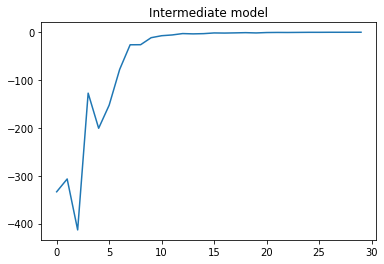

Params to learn for finetuning:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.down

In [ ]:
for e in range(1, n_ensemble + 1):
       
    # Intermediate model
    model = models.resnet50(pretrained=True)
    set_parameter_requires_grad(model, feature_extract_im)
    num_ftrs = model.fc.in_features
    new_layers = get_output_layers(dropout, num_ftrs, num_classes)
    model.fc = new_layers # last fully connected layer
    
    # Send the model to GPU
    model = model.to(device)
    
    # create datalaoders with specific batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size_im)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_im)
    dataloaders_dict = {"train":train_loader,"val":test_loader}
    
    # Create Optimizer and define params to update
    params_to_update = model.parameters()
    print('Params to learn for intermediate training:')
    if feature_extract_im:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Instantiate optimizer for intermediate model
    optimizer = optim.Adam(params_to_update, lr = lr_im)
    
    # Setup the loss fxn
    criterion = get_criterion('L2')
    
    # Initial training and evaluate
    model, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs_im)
    
    # Plot learning curve
    plt.plot(hist)
    plt.title('Intermediate model')
    plt.show()
    
    # Save intermediate model
    PATH = 'CNN_checkpoints/state_dict_intermediate_model.pt'
    torch.save(model.state_dict(), PATH)

    
    # Fine tuned model
    model = models.resnet50()
    set_parameter_requires_grad(model, feature_extract_ft)
    num_ftrs = model.fc.in_features
    new_layers = get_output_layers(dropout, num_ftrs, num_classes)
    model.fc = new_layers # last fully connected layer
    
    # Load pre-trained intermediate model
    model.load_state_dict(torch.load(PATH))
       
    # Send the model to GPU
    model = model.to(device)

    # create datalaoders with specific batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size_ft)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_ft)
    dataloaders_dict = {"train":train_loader,"val":test_loader}
            
    # Create Optimizer and define params to update
    params_to_update = model.parameters()
    print('Params to learn for finetuning:')
    if feature_extract_ft:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # Instantiate optimizer for finetuning
    optimizer = optim.SGD(params_to_update, lr = lr_ft, momentum = 0.9)
    
    # Setup the loss fxn
    criterion = get_criterion("L2")

    # Train and evaluate fine tuned model
    model, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs_ft)
    
    # Plot learning curve
    plt.plot(hist)
    plt.title(f'Ensemble model {e}')
    plt.show()
    
    # Save intermediate model
    PATH = f'CNN_checkpoints/state_dict_ensemble_model_{e}.pt'
    torch.save(model.state_dict(), PATH)